In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Datasets/LWF_DATASET/lfw.zip

In [ ]:
import torch
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.autograd as Variable
import torch.optim as optim

In [ ]:
path_lfw_folder='./gdrive/MyDrive/Datasets/LWF_DATASET'

In [ ]:
class LFW(Dataset):
  def __init__(self,root_dir,txt_path,transforms1,transforms2):  ######### why two transforms?
    self.transform1=transform1
    self.transform2=transform2
    self.root_dir=root_dir

    with open(txt_path) as f:
      lines=f.readlines()

      self.pair_imgs_label=[ line.split() for line in lines]

  def __len__(self):
    return len(self.pair_imgs_label)

  def __getitem__(self,idx):
    img1_path=os.path.join(self.root_dir,self.pair_imgs_label[idx][0])
    img2_path=os.path.join(self.root_dir,self.pair_imgs_label[idx][1])
    label= float(self.pair_imgs_label[idx][2])
    
    img1=cv2.imread(img1_path)
    img1=img1.astype(np.float)/255                                   # why these transformations?
    img1=cv2.resize(img1,(128,128),interpolation=cv2.INTER_AREA)
    img1=self.transform1(img1)
    
    img2=cv2.imread(img2_path)
    img2=img2.astype(np.float)/255
    img2=cv2.resize(img2,(128,128),interpolation=cv2.INTER_AREA)
    img2=self.transform1(img2)
    
    return img1,img2,torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
class Rescale(object):                                          ###################################
    def __call__(self, img):
        if random.random()<0.7:
            f = round(0.1*random.randint(7, 13),2)
            if f>1:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_CUBIC)
                a = int(round((f*128-128)/2))
                img = img[a:a+128,a:a+128]
            else:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_AREA)
                a= int(round((128-f*128)/2))
                temp=np.zeros([128,128,3],dtype=np.uint8)
                temp.fill(0) 
                for i in range(img.shape[0]):
                    for j in range(img.shape[1]):
                        temp[i+a,j+a]=img[i,j]
                img=temp
        return img

class Flip(object):
    def __call__(self,img):
        if random.random()<0.7:
            return cv2.flip(img,1)
        return img
        
class Rotate(object):
    def __call__(self,img):
        if random.random()<0.7:
            angle=random.random()*60-30
            rows,cols,cn = img.shape
            M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
            img = cv2.warpAffine(img,M,(cols,rows))
            return img
        return img

class Translate(object):
    def __call__(self,img):
        if random.random()<0.7:
            x=random.random()*20-10
            y=random.random()*20-10
            rows,cols,cn = img.shape
            M= np.float32([[1,0,x],[0,1,y]])
            img = cv2.warpAffine(img,M,(cols,rows))
        return img

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    
    self.conv1 = nn.Sequential(
        # input = 3*128*128
        nn.Conv2d(3,24,5,1,2),
        # output= 24*128*128
        nn.ReLU(),
        nn.BatchNorm2d(24),
        # input = 24*128*128
        nn.MaxPool2d(3,2),
        # output = 24*63*63
        )
    self.conv2 = nn.Sequential(
        # input = 24*63*63
        nn.Conv2d(24,48,5,1,2),
        # output = 48*63*63
        nn.ReLU(),
        nn.BatchNorm2d(48),
        # input = 48*63*63
        nn.MaxPool2d(3,2),
        # output= 48*31*31
        )
    self.conv3 = nn.Sequential(
        # input = 48*31*31
        nn.Conv2d(48,128,3,2),
        # output= 128*15*15
        nn.ReLU(),
        nn.BatchNorm2d(128),
        )
    self.conv4 =nn.Sequential(
        # input = 128*15*15
        nn.Conv2d(128,192,3,1),
        # input = 192*13*13
        nn.ReLU(),
        nn.BatchNorm2d(192),
        )
    self.conv5 =nn.Sequential(
        # input = 192*13*13
        nn.Conv2d(192,128,3,1),
        # input = 128*11*11
        nn.ReLU(),
        nn.BatchNorm2d(128),
        )
    # self.fc1_sim = nn.Sequential(
    #     nn.Linear(128*11*11,4096),
    #     nn.Sigmoid(),
    #     )   
    # self.fc2_sim = nn.Sequential(
    #     nn.Linear(4096,1),
    #     )
    self.fc1= nn.Sequential(
        nn.Linear(128*11*11,1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
    )
    self.fc2= nn.Sequential(
        nn.Linear(2048,1),
        nn.Sigmoid(),
    )

  def convs(self,x):
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    x=x.view(-1,128*11*11)
    x=self.fc1(x)
    return x

  def forward(self,x1,x2):
    x1= self.convs(x1)
    x2= self.convs(x2)

    x=torch.cat((x1,x2),1)
    x=self.fc2(x)

    # For distance function method
    # x=torch.abs(x1-x2)
    # x= self.fc2(x)

    return x

In [ ]:
def train(model,train_loader,num_epochs,criterion,save_name):
  train_losses=[]
  for epoch in range(num_epochs):
    running_loss=0.0
    print("Starting epoch " + str(epoch+1))
    model.train()
    for i,data in enumerate(train_loader,0):
      imgs1,imgs2,labels=data
      
      imgs1=imgs1.to(device=device, dtype=torch.float)
      imgs2=imgs2.to(device=device, dtype=torch.float)
      labels=labels.to(device=device, dtype=torch.float)

      optimizer.zero_grad()
      outputs=model(imgs1,imgs2)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      running_loss+=loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print('Epoch [{}/{}],Train Loss: {:.4f}'.format(epoch+1, num_epochs, avg_train_loss))
  print("Training completed.")
  
  torch.save(model.state_dict(),save_name)
  
  fig = plt.figure()
  ax = plt.subplot(111)
  ax.plot(train_losses)    
  plt.xlabel('Steps')  
  plt.ylabel('Loss')  
  fig.savefig(os.path.join(path_lfw_folder,'Loss_Steps.png')) 

  return train_losses


In [ ]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

In [ ]:
transform1 = transforms.Compose([Rescale(),Flip(),Translate(),Rotate(),transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
transform2 = transforms.Compose([Rescale(),Flip(),Translate(),Rotate(),transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   
             
train_set = LFW('./lfw/lfw',os.path.join(path_lfw_folder,'lfw_train_pairs.txt'),transform1,transform2)                                 ###############
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.0006
num_epoches = 50
siameseBaseModel=Net()
siameseBaseModel.to(device)

optimizer = optim.Adam(siameseBaseModel.parameters(), lr)
criterion = nn.BCELoss() 
save_path=os.path.join(path_lfw_folder,'siameseBaseModel.pt')

count_parameters(siameseBaseModel)

Running on gpu
The model architecture:

 Net(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_st

Starting epoch 1
Epoch [1/50],Train Loss: 0.9931
Starting epoch 2
Epoch [2/50],Train Loss: 0.7058
Starting epoch 3
Epoch [3/50],Train Loss: 0.6962
Starting epoch 4
Epoch [4/50],Train Loss: 0.7091
Starting epoch 5
Epoch [5/50],Train Loss: 0.6931
Starting epoch 6
Epoch [6/50],Train Loss: 0.6908
Starting epoch 7
Epoch [7/50],Train Loss: 0.6932
Starting epoch 8
Epoch [8/50],Train Loss: 0.7094
Starting epoch 9
Epoch [9/50],Train Loss: 0.6903
Starting epoch 10
Epoch [10/50],Train Loss: 0.6876
Starting epoch 11
Epoch [11/50],Train Loss: 0.6866
Starting epoch 12
Epoch [12/50],Train Loss: 0.6862
Starting epoch 13
Epoch [13/50],Train Loss: 0.6740
Starting epoch 14
Epoch [14/50],Train Loss: 0.7007
Starting epoch 15
Epoch [15/50],Train Loss: 0.6837
Starting epoch 16
Epoch [16/50],Train Loss: 0.6857
Starting epoch 17
Epoch [17/50],Train Loss: 0.6747
Starting epoch 18
Epoch [18/50],Train Loss: 0.6864
Starting epoch 19
Epoch [19/50],Train Loss: 0.6725
Starting epoch 20
Epoch [20/50],Train Loss: 0.674

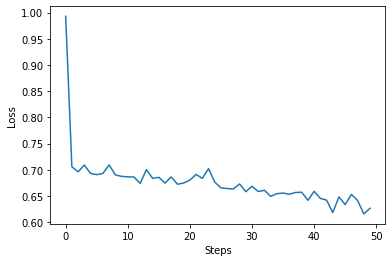

In [22]:
train_loss_his=train(siameseBaseModel,train_loader,num_epoches,criterion,save_path)